In [5]:
import os
#Define the path to kaggle.json file
source_path = "/Users/atishdhamala/Downloads/kaggle.json"

# Create the .kaggle directory in your home directory if it doesn't exist.
os.makedirs(os.path.join(os.path.expanduser("~"), ".kaggle"), exist_ok=True)

# Copy the kaggle.json file to the .kaggle folder (this command might vary slightly on Windows)
!cp {source_path} ~/.kaggle/kaggle.json

# Adjust file permissions
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!pip install kaggle --quiet

In [6]:
# Create a directory to store the APTOS dataset
data_dir = os.path.join("data", "aptos")
os.makedirs(data_dir, exist_ok=True)

# Download the dataset using Kaggle API
!kaggle competitions download -c aptos2019-blindness-detection -p {data_dir}


In [4]:
data_dir = "/Users/atishdhamala/Eye Disease Detection using Deep Learning/data/aptos"

In [7]:
import zipfile
# Extract the downloaded zip files
for filename in os.listdir(data_dir):
    if filename.endswith(".zip"):
        zip_path = os.path.join(data_dir, filename)
        print(f"Extracting {zip_path} ...")
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(data_dir)
        except zipfile.BadZipFile:
            print(f"Error: {zip_path} is not a valid zip file.")


Extracting data/aptos/aptos2019-blindness-detection.zip ...


In [1]:
pip install pandas torch torchvision matplotlib scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import os

csv_path = os.path.join(data_dir, "train.csv")
aptos_df = pd.read_csv(csv_path)
print("APTOS Dataset CSV Preview:")
print(aptos_df.head())

APTOS Dataset CSV Preview:
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [15]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np

## Data Preprocessing and Augmentation

In [7]:
class APTOSDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, binary=True):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.binary = binary
        
        if self.binary:
            self.df['class'] = self.df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)
        else:
            self.df['class'] = self.df['diagnosis']
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        filename = f"{record['id_code']}.png" 
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(record['class'])
        return image, label

In [8]:
# Define basic image transformations.
transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

In [9]:
# Specify the paths
csv_path = os.path.join("data", "aptos", "train.csv") 
img_dir  = os.path.join("data", "aptos", "train_images")

In [10]:
# Instantiate the dataset and DataLoader.
aptos_dataset = APTOSDataset(csv_file=csv_path, img_dir=img_dir, transform=transform, binary=True)
aptos_loader = DataLoader(aptos_dataset, batch_size=32, shuffle=True, num_workers=0)

In [11]:
# Load one batch and display shapes
images, labels = next(iter(aptos_loader))
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])


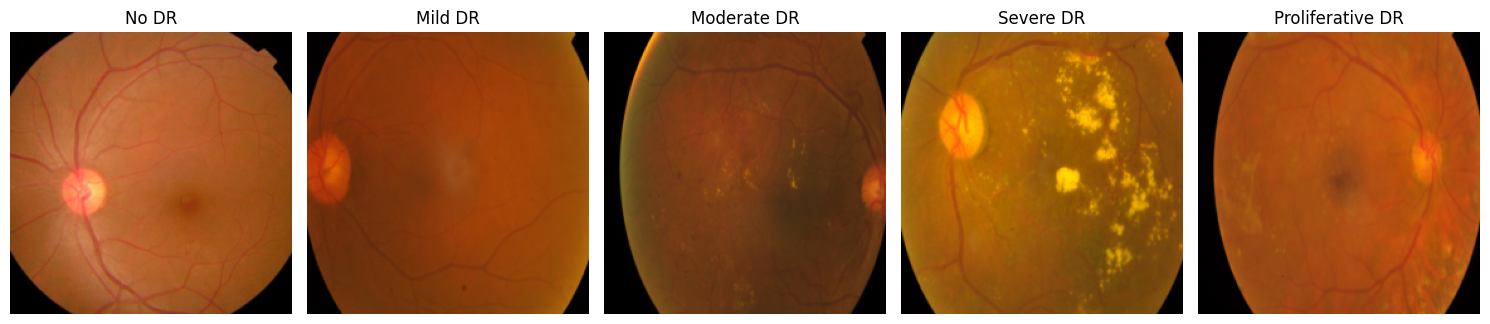

In [16]:

# Define a mapping for the 5-class APTOS dataset:
label_map = {
    0: "No DR",
    1: "Mild DR",
    2: "Moderate DR",
    3: "Severe DR",
    4: "Proliferative DR"
}

# Create a dictionary to store one index for each label.
sample_indices = {}
for label in range(5):
    # Get all indices where the diagnosis column equals the current label.
    indices = aptos_df[aptos_df['diagnosis'] == label].index.tolist()
    if len(indices) > 0:
        sample_indices[label] = indices[0]  # take the first occurrence
    else:
        print(f"No sample found for label {label}")

# using these indices, load the corresponding images from the dataset.
sample_images = {}
for label, idx in sample_indices.items():
    image, lab = aptos_dataset[idx]
    sample_images[label] = image

# Define the imshow function to de-normalize and display an image.
def imshow(img, title=None):
    """
    Display an image tensor after de-normalization.
    
    Args:
      img (Tensor): Image tensor (3, H, W) normalized with ImageNet stats.
      title (str, optional): Title for the image.
    """
    img = img.cpu().numpy()
    # Change from CHW to HWC for display.
    img = np.transpose(img, (1, 2, 0))
    # Reverse ImageNet normalization.
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# Plot a row of images: one per diagnosis label
plt.figure(figsize=(15, 4))
for i, label in enumerate(range(5)):
    plt.subplot(1, 5, i+1)
    imshow(sample_images[label], title=label_map[label])
plt.tight_layout()
plt.show()

## Train-Test Split

In [17]:
from sklearn.model_selection import train_test_split

# Load the original APTOS CSV (make sure the path matches your structure)
csv_path = os.path.join("data", "aptos", "train.csv")
aptos_df = pd.read_csv(csv_path)

# Stratified split: 80% train, 20% validation based on 'diagnosis'
train_df, val_df = train_test_split(aptos_df, test_size=0.2, stratify=aptos_df['diagnosis'], random_state=42)

# Save the splits to CSV files (optional but can be useful for reproducibility)
train_csv = os.path.join("data", "aptos", "train_split.csv")
val_csv = os.path.join("data", "aptos", "val_split.csv")
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)

print("Train and validation splits created.")
print("Train set distribution:")
print(train_df['diagnosis'].value_counts().sort_index())
print("\nValidation set distribution:")
print(val_df['diagnosis'].value_counts().sort_index())

Train and validation splits created.
Train set distribution:
diagnosis
0    1444
1     296
2     799
3     154
4     236
Name: count, dtype: int64

Validation set distribution:
diagnosis
0    361
1     74
2    200
3     39
4     59
Name: count, dtype: int64


In [18]:
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Training data augmentation
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),        # Data augmentation
    T.RandomRotation(15),            # Random rotation for more variety
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [19]:
img_dir = os.path.join("data", "aptos", "train_images")

# Create dataset objects for training and validation (using multi-class, so binary=False)
aptos_train = APTOSDataset(csv_file=train_csv, img_dir=img_dir, transform=train_transform, binary=False)
aptos_val = APTOSDataset(csv_file=val_csv, img_dir=img_dir, transform=val_transform, binary=False)

# Create DataLoaders
train_loader = DataLoader(aptos_train, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(aptos_val, batch_size=32, shuffle=False, num_workers=0)

print("Training and Validation DataLoaders created.")

Training and Validation DataLoaders created.


In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns

## ResNet50 : Full Layers

In [48]:
# Load pretrained ResNet50.
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer for 5 output classes.
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)

# Move the model to GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Model, loss function, and optimizer are set up.")

/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/atishdhamala/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 29.2MB/s]

Model, loss function, and optimizer are set up.


In [22]:
!pip install torchsummary


In [63]:
# Assuming your model's input size is (3, 224, 224)
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [49]:
num_epochs = 5  # adjust based on your needs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training loop
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        # Get predictions
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    epoch_loss = running_loss / total_train
    train_acc = (correct_train / total_train) * 100
    
    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = running_val_loss / total_val
    val_acc = (correct_val / total_val) * 100
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


Epoch [1/5] | Train Loss: 0.6556 | Train Acc: 76.44% | Val Loss: 0.5442 | Val Acc: 78.31%
Epoch [2/5] | Train Loss: 0.4812 | Train Acc: 82.52% | Val Loss: 0.5545 | Val Acc: 80.49%
Epoch [3/5] | Train Loss: 0.3924 | Train Acc: 86.10% | Val Loss: 0.5091 | Val Acc: 80.35%
Epoch [4/5] | Train Loss: 0.3492 | Train Acc: 87.27% | Val Loss: 0.5524 | Val Acc: 79.81%
Epoch [5/5] | Train Loss: 0.2976 | Train Acc: 89.07% | Val Loss: 0.6753 | Val Acc: 80.35%


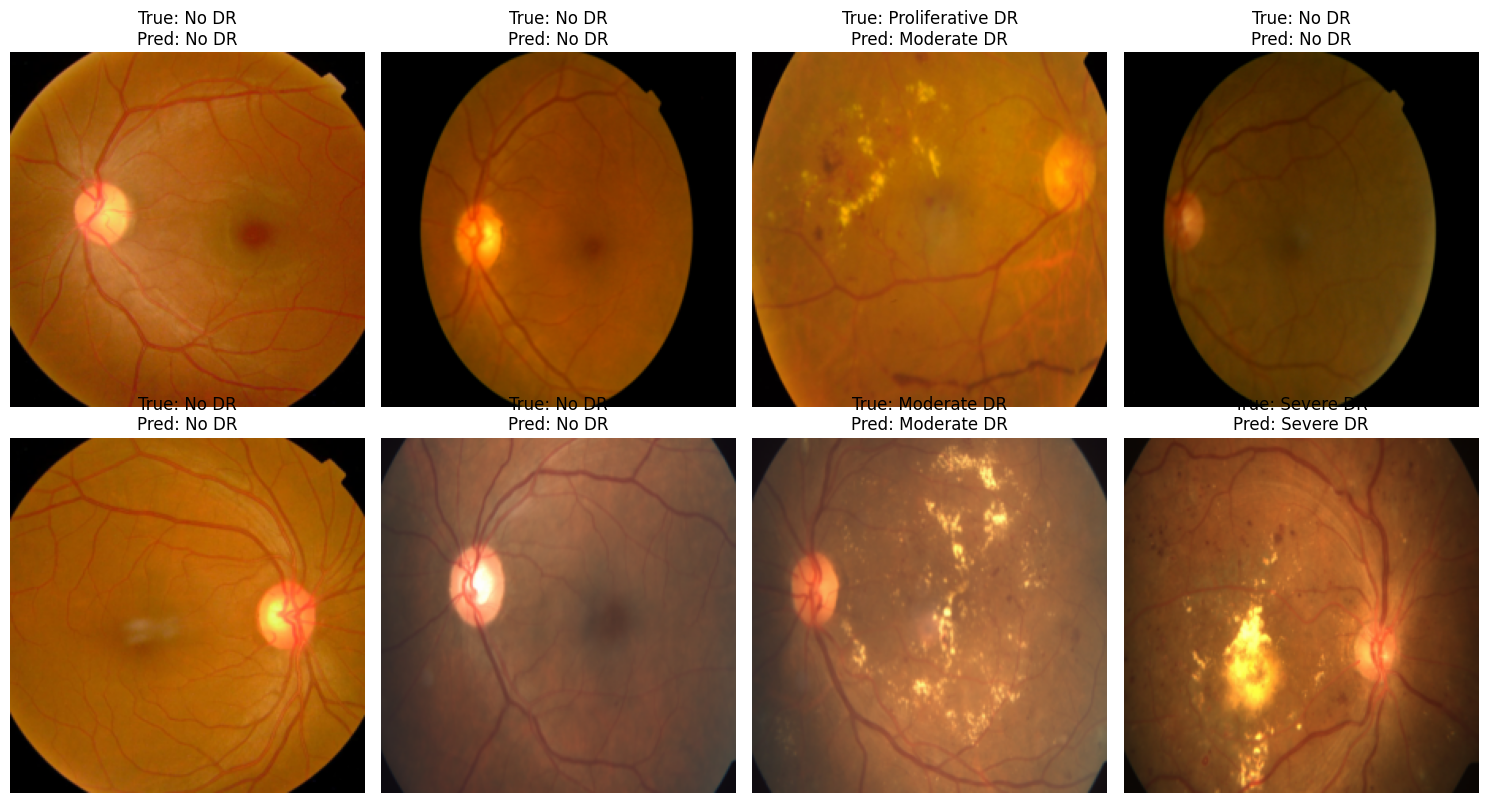

In [50]:
# Set the model to evaluation mode.
model.eval()

# Disable gradient computation for inference.
with torch.no_grad():
    # Get one batch from the validation DataLoader.
    images, labels = next(iter(val_loader))
    
    # Move the batch to the correct device.
    images = images.to(device)
    labels = labels.to(device)
    
    # Perform prediction on the batch.
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    # Move predictions and labels to CPU for visualization.
    preds = preds.cpu().numpy()
    true_labels = labels.cpu().numpy()

# Plot a subset of images (for instance, 8 images)
plt.figure(figsize=(15, 8))
num_images = 8  # Adjust how many images you'd like to display
for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    # Display each image with both true and predicted labels.
    imshow(images[i], title=f"True: {label_map[true_labels[i]]}\nPred: {label_map[preds[i]]}")
plt.tight_layout()
plt.show()

In [20]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


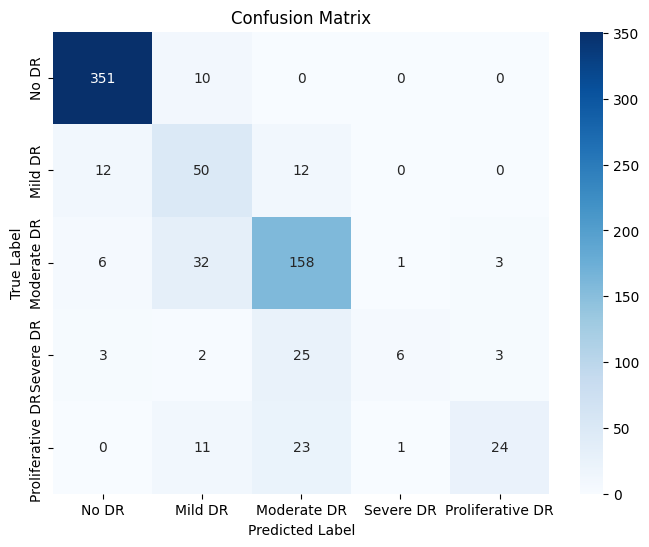

In [57]:
# Collect true labels and predictions for the entire validation set.
all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Compute the confusion matrix.
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in range(5)],
            yticklabels=[label_map[i] for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

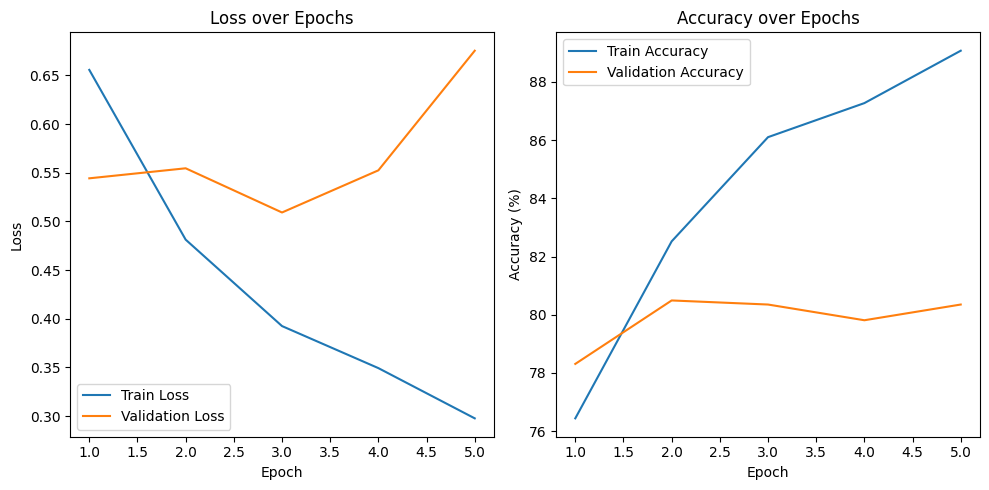

In [60]:
# Example metrics taken from your output
train_losses = [0.6556, 0.4812, 0.3924, 0.3492, 0.2976]
val_losses   = [0.5442, 0.5545, 0.5091, 0.5524, 0.6753]
train_accs   = [76.44, 82.52, 86.10, 87.27, 89.07]
val_accs     = [78.31, 80.49, 80.35, 79.81, 80.35]
epochs = range(1, 6)

import matplotlib.pyplot as plt

# Plot Loss and Accuracy curves.
plt.figure(figsize=(10, 5))

# Loss Plot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


## ResNet50: Fine Tuned final block and fully connected layer

In [65]:
resnet_new = models.resnet50(pretrained=True)
num_features = resnet_new.fc.in_features
# Replace the final fully-connected layer with one that outputs 5 classes.
resnet_new.fc = nn.Linear(num_features, 5)

# Freeze all layers first.
for param in resnet_new.parameters():
    param.requires_grad = False

# Unfreeze the parameters in the final block (layer4) and the final FC layer.
for param in resnet_new.layer4.parameters():
    param.requires_grad = True
for param in resnet_new.fc.parameters():
    param.requires_grad = True

# Move the model to the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_new = resnet_new.to(device)

# Set up the optimizer with differential learning rates.
optimizer = torch.optim.Adam([
    {"params": resnet_new.fc.parameters(), "lr": 1e-3},
    {"params": resnet_new.layer4.parameters(), "lr": 1e-4},
], weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

# (Optional) Learning rate scheduler to reduce LR when validation loss plateaus.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [66]:
summary(resnet_new, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [67]:
# Initialize lists to save metrics.
train_losses, train_accs = [], []
val_losses, val_accs = [], []
num_epochs = 5 

for epoch in range(num_epochs):
    resnet_new.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training loop for one epoch.
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    epoch_loss = running_loss / total_train
    train_accuracy = (correct_train / total_train) * 100
    
    # Save training metrics.
    train_losses.append(epoch_loss)
    train_accs.append(train_accuracy)
    
    # Validation loop for one epoch.
    resnet_new.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet_new(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    
    val_loss = running_val_loss / total_val
    val_accuracy = (correct_val / total_val) * 100
    
    # Save validation metrics.
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    
    # Update the learning rate scheduler.
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Training Accuracies:", train_accs)
print("Validation Accuracies:", val_accs)

Epoch [1/5] | Train Loss: 0.2644 | Train Acc: 89.38% | Val Loss: 0.6753 | Val Acc: 80.35%
Epoch [2/5] | Train Loss: 0.2598 | Train Acc: 89.07% | Val Loss: 0.6753 | Val Acc: 80.35%
Epoch [3/5] | Train Loss: 0.2628 | Train Acc: 89.42% | Val Loss: 0.6753 | Val Acc: 80.35%
Epoch [4/5] | Train Loss: 0.2666 | Train Acc: 89.11% | Val Loss: 0.6753 | Val Acc: 80.35%
Epoch [5/5] | Train Loss: 0.2621 | Train Acc: 89.93% | Val Loss: 0.6753 | Val Acc: 80.35%
Training Losses: [0.264358497797405, 0.2597888532088616, 0.26278893993998925, 0.2665773813316097, 0.2620504824689485]
Validation Losses: [0.6752707995626807, 0.6752707995626807, 0.6752707995626807, 0.6752707995626807, 0.6752707995626807]
Training Accuracies: [89.3820416524411, 89.0747695459201, 89.41618299761011, 89.10891089108911, 89.9283031751451]
Validation Accuracies: [80.35470668485675, 80.35470668485675, 80.35470668485675, 80.35470668485675, 80.35470668485675]


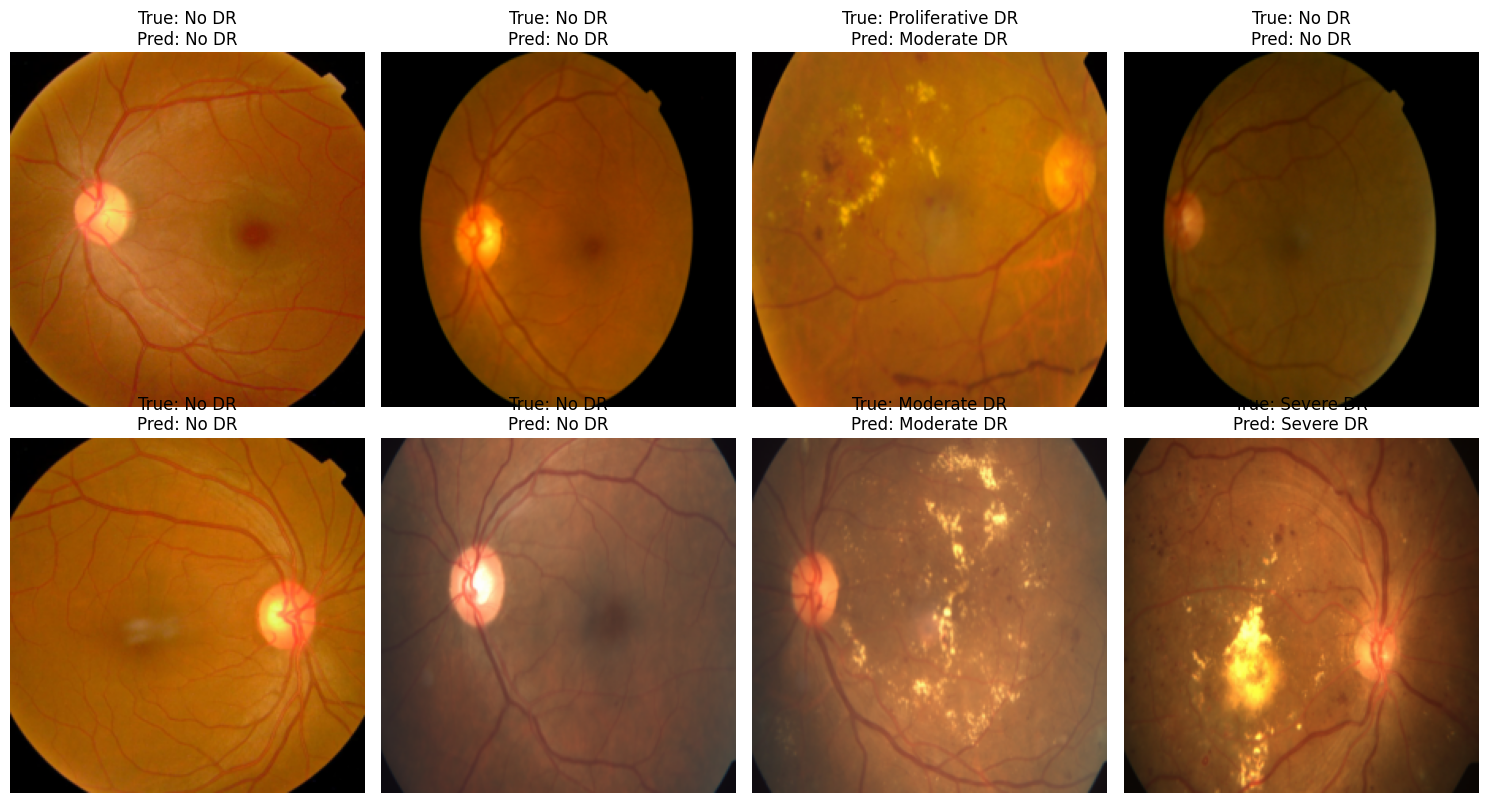

In [68]:
# Set the model to evaluation mode.
resnet_new.eval()

# Disable gradient computation for inference.
with torch.no_grad():
    # Get one batch from the validation DataLoader.
    images, labels = next(iter(val_loader))
    
    # Move the batch to the correct device.
    images = images.to(device)
    labels = labels.to(device)
    
    # Perform prediction on the batch.
    outputs = resnet_new(images)
    _, preds = torch.max(outputs, 1)
    
    # Move predictions and labels to CPU for visualization.
    preds = preds.cpu().numpy()
    true_labels = labels.cpu().numpy()

# Plot a subset of images (for instance, 8 images)
plt.figure(figsize=(15, 8))
num_images = 8  # Adjust how many images you'd like to display
for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    # Display each image with both true and predicted labels.
    imshow(images[i], title=f"True: {label_map[true_labels[i]]}\nPred: {label_map[preds[i]]}")
plt.tight_layout()
plt.show()

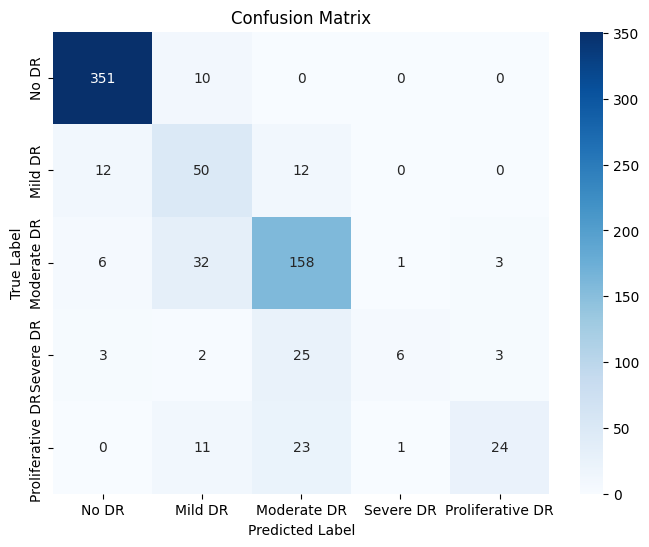

In [69]:
# Collect true labels and predictions for the entire validation set.
all_preds = []
all_true = []

resnet_new.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet_new(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Compute the confusion matrix.
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in range(5)],
            yticklabels=[label_map[i] for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

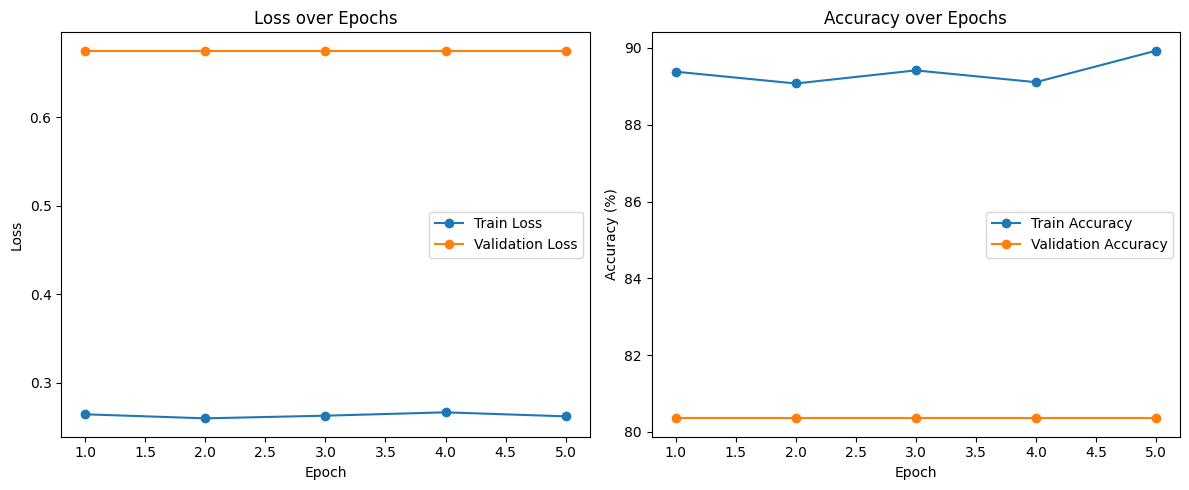

In [70]:
# Number of epochs (should match num_epochs used during training)
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'o-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## EfficientNet-B0 :  Full layers (Trained for 10 epochs)

In [24]:
# 1. Load EfficientNet-B0 pretrained on ImageNet.
efficientnet = models.efficientnet_b0(pretrained=True)

# 2. Replace the classifier to output 5 classes.
# EfficientNet-B0's classifier is typically a Sequential containing a Dropout and a Linear layer.
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_features, 5)

# 3. Freeze the base parameters.
# We'll freeze all parameters first, then unfreeze the classifier.
for param in efficientnet.parameters():
    param.requires_grad = False

# Unfreeze the classifier parameters so that they can be trained.
for param in efficientnet.classifier.parameters():
    param.requires_grad = True

# 4. Move the model to the available device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet = efficientnet.to(device)

# 5. Set up the optimizer.
# We use a higher learning rate for the classifier and a lower one for any fine-tuned features.
optimizer = torch.optim.Adam([
    {"params": efficientnet.classifier.parameters(), "lr": 1e-3},
], weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

# (Optional) Learning Rate Scheduler to reduce LR if validation loss plateaus.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)


/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [25]:
summary(efficientnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [26]:
# 6. Initialize lists to save metrics.
train_losses, train_accs = [], []
val_losses, val_accs = [], []
num_epochs = 10

# 7. Training Loop
for epoch in range(num_epochs):
    efficientnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    train_accuracy = (correct_train / total_train) * 100
    train_losses.append(epoch_loss)
    train_accs.append(train_accuracy)

    # Validation phase
    efficientnet.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = efficientnet(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / total_val
    val_accuracy = (correct_val / total_val) * 100
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Training Accuracies:", train_accs)
print("Validation Accuracies:", val_accs)

Epoch [1/10] | Train Loss: 0.9438 | Train Acc: 67.19% | Val Loss: 0.7817 | Val Acc: 73.26%
Epoch [2/10] | Train Loss: 0.7229 | Train Acc: 73.98% | Val Loss: 0.7126 | Val Acc: 74.90%
Epoch [3/10] | Train Loss: 0.6806 | Train Acc: 74.39% | Val Loss: 0.7026 | Val Acc: 74.76%
Epoch [4/10] | Train Loss: 0.6530 | Train Acc: 76.00% | Val Loss: 0.6788 | Val Acc: 75.17%
Epoch [5/10] | Train Loss: 0.6371 | Train Acc: 76.92% | Val Loss: 0.6678 | Val Acc: 76.26%
Epoch [6/10] | Train Loss: 0.6223 | Train Acc: 76.75% | Val Loss: 0.6738 | Val Acc: 76.26%
Epoch [7/10] | Train Loss: 0.6077 | Train Acc: 77.36% | Val Loss: 0.6602 | Val Acc: 76.94%
Epoch [8/10] | Train Loss: 0.5938 | Train Acc: 78.25% | Val Loss: 0.6561 | Val Acc: 75.85%
Epoch [9/10] | Train Loss: 0.5958 | Train Acc: 77.53% | Val Loss: 0.6572 | Val Acc: 76.26%
Epoch [10/10] | Train Loss: 0.5870 | Train Acc: 78.56% | Val Loss: 0.6540 | Val Acc: 76.94%
Training Losses: [0.9438110544193967, 0.7229497186882824, 0.6806433289764928, 0.653001525

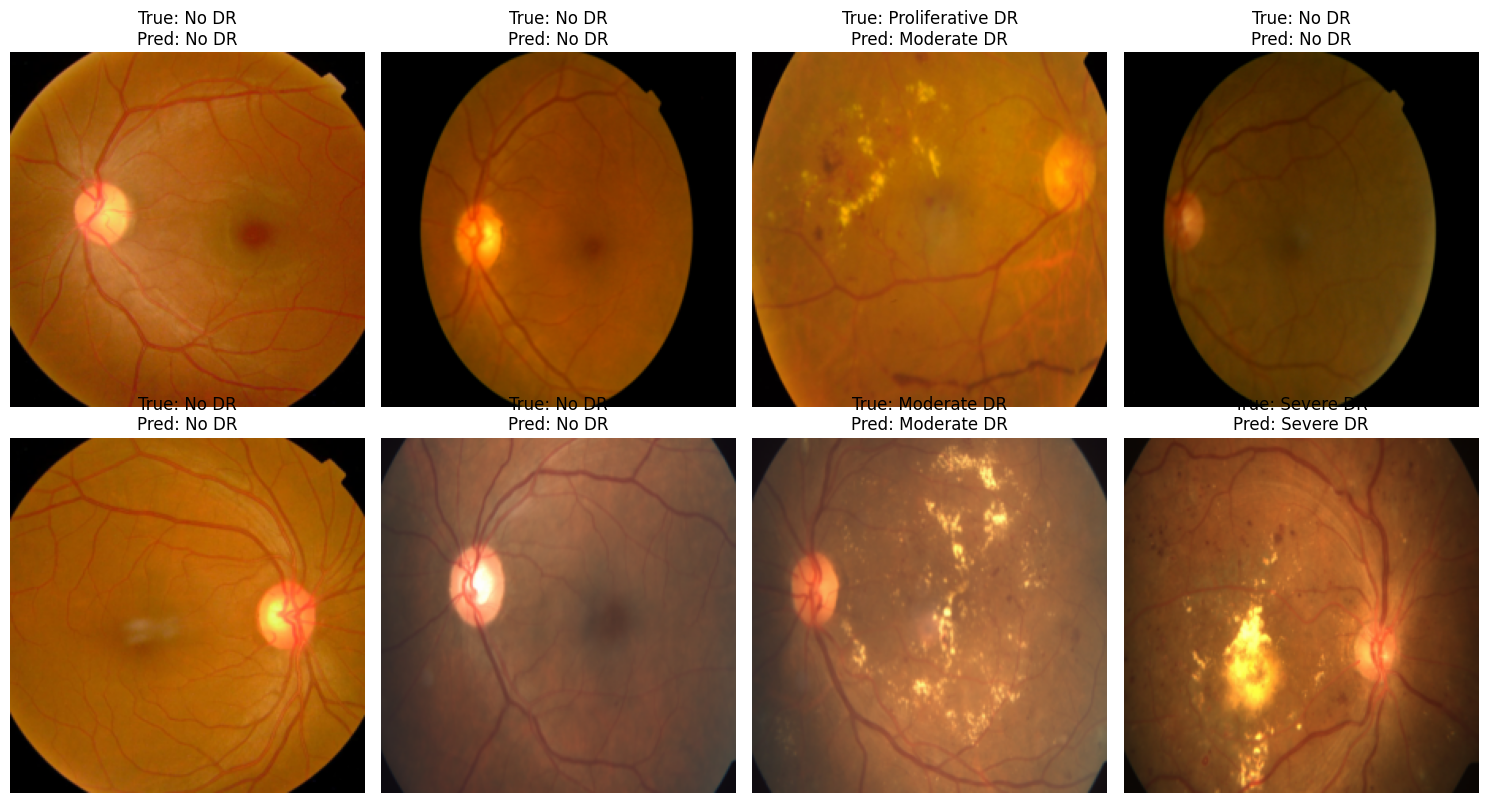

In [28]:
# Set the model to evaluation mode.
efficientnet.eval()

# Disable gradient computation for inference.
with torch.no_grad():
    # Get one batch from the validation DataLoader.
    images, labels = next(iter(val_loader))
    
    # Move the batch to the correct device.
    images = images.to(device)
    labels = labels.to(device)
    
    # Perform prediction on the batch.
    outputs = efficientnet(images)
    _, preds = torch.max(outputs, 1)
    
    # Move predictions and labels to CPU for visualization.
    preds = preds.cpu().numpy()
    true_labels = labels.cpu().numpy()

# Plot a subset of images (for instance, 8 images)
plt.figure(figsize=(15, 8))
num_images = 8  # Adjust how many images you'd like to display
for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    # Display each image with both true and predicted labels.
    imshow(images[i], title=f"True: {label_map[true_labels[i]]}\nPred: {label_map[preds[i]]}")
plt.tight_layout()
plt.show()

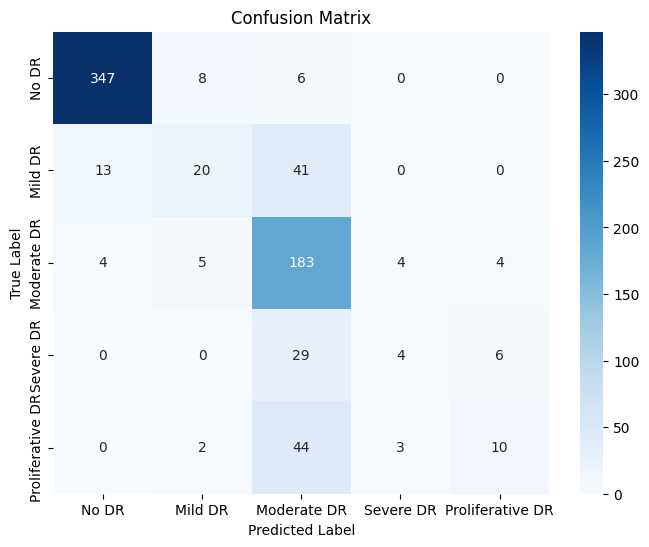

In [30]:
# Collect true labels and predictions for the entire validation set.
all_preds_eff = []
all_true_eff = []

efficientnet.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = efficientnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds_eff.extend(preds.cpu().numpy())
        all_true_eff.extend(labels.cpu().numpy())

# Compute the confusion matrix.
cm_eff = confusion_matrix(all_true_eff, all_preds_eff)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in range(5)],
            yticklabels=[label_map[i] for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

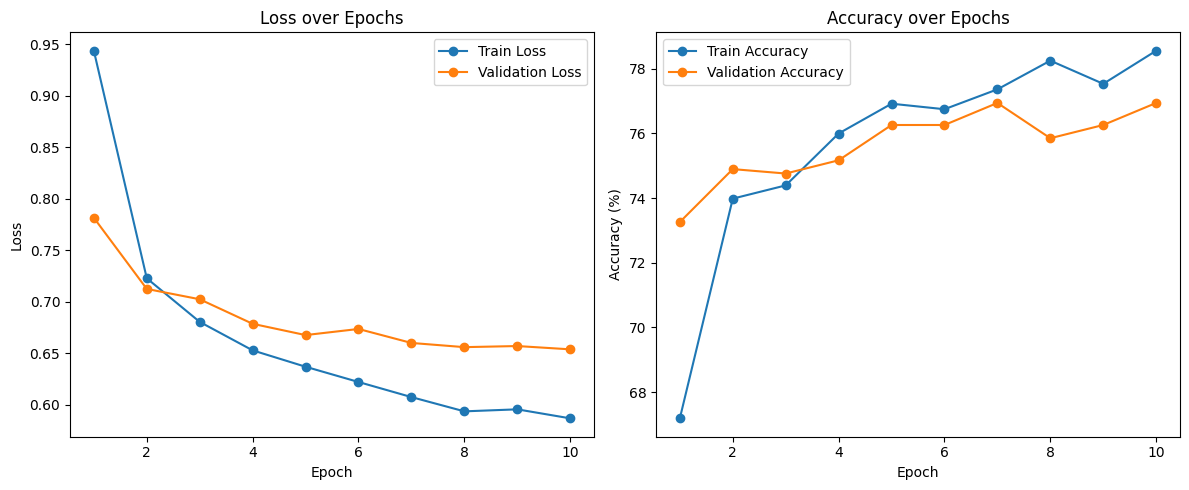

In [32]:
# Number of epochs (should match num_epochs used during training)
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'o-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## EfficientNet- B0 : Trained for 30 epochs

In [33]:
efficientnet_30 = models.efficientnet_b0(pretrained=True)
num_features = efficientnet_30.classifier[1].in_features
efficientnet_30.classifier[1] = nn.Linear(num_features, 5)

for param in efficientnet_30.parameters():
    param.requires_grad = False

for param in efficientnet_30.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_30 = efficientnet_30.to(device)

optimizer = torch.optim.Adam([
    {"params": efficientnet_30.classifier.parameters(), "lr": 1e-3},
], weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/atishdhamala/Computer Vision Workshop/cvworkshop/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [34]:
summary(efficientnet_30, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [36]:
# 6. Initialize lists to save metrics.
train_losses, train_accs = [], []
val_losses, val_accs = [], []
num_epochs = 30

# 7. Training Loop
for epoch in range(num_epochs):
    efficientnet_30.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_30(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    train_accuracy = (correct_train / total_train) * 100
    train_losses.append(epoch_loss)
    train_accs.append(train_accuracy)

    # Validation phase
    efficientnet_30.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = efficientnet(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / total_val
    val_accuracy = (correct_val / total_val) * 100
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)

    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Training Accuracies:", train_accs)
print("Validation Accuracies:", val_accs)

KeyboardInterrupt: 

In [ ]:
# Set the model to evaluation mode.
efficientnet_30.eval()

# Disable gradient computation for inference.
with torch.no_grad():
    # Get one batch from the validation DataLoader.
    images, labels = next(iter(val_loader))
    
    # Move the batch to the correct device.
    images = images.to(device)
    labels = labels.to(device)
    
    # Perform prediction on the batch.
    outputs = efficientnet_30(images)
    _, preds = torch.max(outputs, 1)
    
    # Move predictions and labels to CPU for visualization.
    preds = preds.cpu().numpy()
    true_labels = labels.cpu().numpy()

# Plot a subset of images (for instance, 8 images)
plt.figure(figsize=(15, 8))
num_images = 8  # Adjust how many images you'd like to display
for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    # Display each image with both true and predicted labels.
    imshow(images[i], title=f"True: {label_map[true_labels[i]]}\nPred: {label_map[preds[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
# Collect true labels and predictions for the entire validation set.
all_preds_eff = []
all_true_eff = []

efficientnet_30.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = efficientnet_30(images)
        _, preds = torch.max(outputs, 1)
        all_preds_eff.extend(preds.cpu().numpy())
        all_true_eff.extend(labels.cpu().numpy())

# Compute the confusion matrix.
cm_eff = confusion_matrix(all_true_eff, all_preds_eff)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in range(5)],
            yticklabels=[label_map[i] for i in range(5)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Number of epochs
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'o-', label='Train Accuracy')
plt.plot(epochs, val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()